In [1]:
import sys
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    if root_dir.parts[-1:] == ("src",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("airquality",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("notebooks",):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

print(f"Root dir: {root_dir}")

if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

from utils import config

settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn
Added the following directory to the PYTHONPATH: /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn
HopsworksSettings initialized!


## Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from utils import airquality
from collections import defaultdict
import json
import warnings

warnings.filterwarnings("ignore")

## Setup

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value

# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name="air_quality_all",
    version=1,
)
weather_fg = fs.get_feature_group(
    name="weather_all",
    version=1,
)

2025-11-18 11:36:53,751 INFO: Initializing external client
2025-11-18 11:36:53,751 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 11:36:55,415 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279179


Set SENSOR_CSV_FILE in .env with the relative path to a sensor to process it, or leave it unset to process all sensors in the `data` folder

In [4]:
sensor_csv_file = getattr(settings, 'SENSOR_CSV_FILE', None)

if sensor_csv_file:
    # Read one secret for single sensor mode
    _, _, _, _, _, sensor_id = airquality.read_sensor_data(sensor_csv_file)
    secret_name = f"SENSOR_LOCATION_JSON_{sensor_id}"
    location_str = secrets.get_secret(secret_name).value
    locations = {sensor_id: json.loads(location_str)}
else:
    # Read all individual secrets in batch mode
    all_secrets = secrets.get_secrets()
    locations = {}
    for secret in all_secrets:
        if secret.name.startswith("SENSOR_LOCATION_JSON_"):
            sensor_id = secret.name.replace("SENSOR_LOCATION_JSON_", "")
            location_str = secrets.get_secret(secret.name).value
            if location_str:
                locations[sensor_id] = json.loads(location_str)


## Script

In [5]:
# Select features for training data
baseline_features = air_quality_fg.select(["pm25", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)

baseline_feature_view = fs.get_or_create_feature_view(
    name="air_quality_baseline_fv",
    description="Weather features for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=baseline_features,
)

rolling_features = air_quality_fg.select(["pm25", "pm25_rolling_3d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
rolling_feature_view = fs.get_or_create_feature_view(
    name="air_quality_rolling_fv",
    description="Weather features, PM2.5 rolling window (3d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=rolling_features,
)

nearby_features = air_quality_fg.select(["pm25", "pm25_nearby_avg", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
nearby_feature_view = fs.get_or_create_feature_view(
    name="air_quality_nearby_fv",
    description="Weather features, PM2.5 nearby average (1d lag, 3 sensors) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=nearby_features,
)

lagged_1d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_1d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_1d_fv",
    description="Weather features, PM2.5 lags (1d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_1d_features,
)

lagged_2d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "pm25_lag_2d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_2d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_2d_fv",
    description="Weather features, PM2.5 lags (1d, 2d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_2d_features,
)

lagged_3d_features = air_quality_fg.select(["pm25", "pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
lagged_3d_feature_view = fs.get_or_create_feature_view(
    name="air_quality_lagged_3d_fv",
    description="Weather features, PM2.5 lags (1d, 2d, 3d) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=lagged_3d_features,
)

complete_features = air_quality_fg.select(["pm25", "pm25_rolling_3d", "pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d", "pm25_nearby_avg", "date", "sensor_id"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)
complete_feature_view = fs.get_or_create_feature_view(
    name="air_quality_complete_fv",
    description="Weather features, PM2.5 rolling window (3d), and PM2.5 lags (1d, 2d, 3d), and PM2.5 nearby average (1d lag, 3 sensors) for PM2.5 prediction",
    version=1,
    labels=["pm25"],
    query=complete_features,
)

2025-11-18 11:37:00,381 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279179/fs/1265797/fv/air_quality_baseline_fv/version/1
2025-11-18 11:37:04,517 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279179/fs/1265797/fv/air_quality_rolling_fv/version/1
2025-11-18 11:37:08,155 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'lo

In [6]:

start_date_test_data = "2025-05-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

models = defaultdict(dict)
y_preds = defaultdict(dict)
results = []

feature_views = {
    "baseline": baseline_feature_view,
    "rolling": rolling_feature_view,
    "nearby": nearby_feature_view,
    "lagged_1d": lagged_1d_feature_view,
    "lagged_2d": lagged_2d_feature_view,
    "lagged_3d": lagged_3d_feature_view,
    "complete": complete_feature_view,
}

In [7]:
for feature_name, feature_view in feature_views.items():
    data = feature_view.query.read()
    data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

    for sensor_id in locations.keys():
        df = data[data['sensor_id'] == sensor_id].copy()
        train_df = df[df['date'] < test_start]
        test_df = df[df['date'] >= test_start]

        # Drop non-feature columns (pm25 is target, others are metadata)
        X_train = train_df.drop(columns=["pm25", "date", "city", "sensor_id"])
        y_train = train_df["pm25"]
        X_test = test_df.drop(columns=["pm25", "date", "city", "sensor_id"])
        y_test = test_df["pm25"]
        
        model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=165439)
        model.fit(X_train, y_train)
        models[feature_name][sensor_id] = model
        y_preds[feature_name][sensor_id] = model.predict(X_test)
        mse = mean_squared_error(y_test, y_preds[feature_name][sensor_id])
        r2 = r2_score(y_test, y_preds[feature_name][sensor_id])
        results.append({
            "feature_name": feature_name,
            "sensor_id": sensor_id,
            "MSE": mse,
            "R2": r2,
            "train_size": len(train_df),
            "test_size": len(test_df)
        })

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.19s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.40s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.07s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.96s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.79s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.66s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.21s) 


In [8]:
model_dir = f"{root_dir}/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [9]:
# Find best model (highest R2) for each sensor
results_df = pd.DataFrame(results)
best_models = results_df.loc[results_df.groupby('sensor_id')['R2'].idxmax()]
print("Best models per sensor:")
print(best_models[['sensor_id', 'feature_name', 'R2', 'MSE']])

all_data = baseline_features.read()
all_data['date'] = pd.to_datetime(all_data['date']).dt.tz_localize(None)

all_test_data = []
for _, row in best_models.iterrows():
    sensor_id = row['sensor_id']
    best_feature = row['feature_name']
    
    sensor_dir = f"{model_dir}/{sensor_id}"
    if not os.path.exists(sensor_dir):
        os.mkdir(sensor_dir)
    images_dir = f"{model_dir}/{sensor_id}/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)

    best_model = models[best_feature][sensor_id]
    model_path = f"{sensor_dir}/model.json"
    best_model.save_model(model_path)

    plot_importance(best_model)
    importance_path = f"{images_dir}/importance.png"
    plt.savefig(importance_path)
    plt.close()
    
    df = all_data[all_data['sensor_id'] == sensor_id].copy()
    test_df = df[df['date'] >= test_start].copy()
    
    if len(test_df) == 0:
        continue
    
    test_df['predicted_pm25'] = y_preds[best_feature][sensor_id]
    test_df['best_model'] = best_feature
    all_test_data.append(test_df[['date', 'pm25', 'predicted_pm25', 'latitude', 'longitude', 'best_model']])

Best models per sensor:
    sensor_id feature_name        R2       MSE
107    112672     complete  0.330900  6.681745
64     154549    lagged_2d  0.178057  9.259364
58     194215    lagged_1d  0.124813  6.426767
53     404209    lagged_1d  0.235534  2.314270
102     59095     complete  0.313745  4.545437
76      59893    lagged_2d  0.517883  0.006810
87      60535    lagged_3d  0.044647  4.408664
33      60541       nearby  0.326911  7.608543
104     60853     complete  0.379577  1.975795
99      61714     complete  0.166421  4.300676
84      65146    lagged_3d  0.506147  0.025523
47      69628       nearby  0.243492  7.348084
61      69724    lagged_1d  0.213009  5.322255
18      79750      rolling -0.549977  1.384731
94      81505    lagged_3d  0.223475  8.365528
105     88372     complete  0.285493  3.889343
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.82s) 


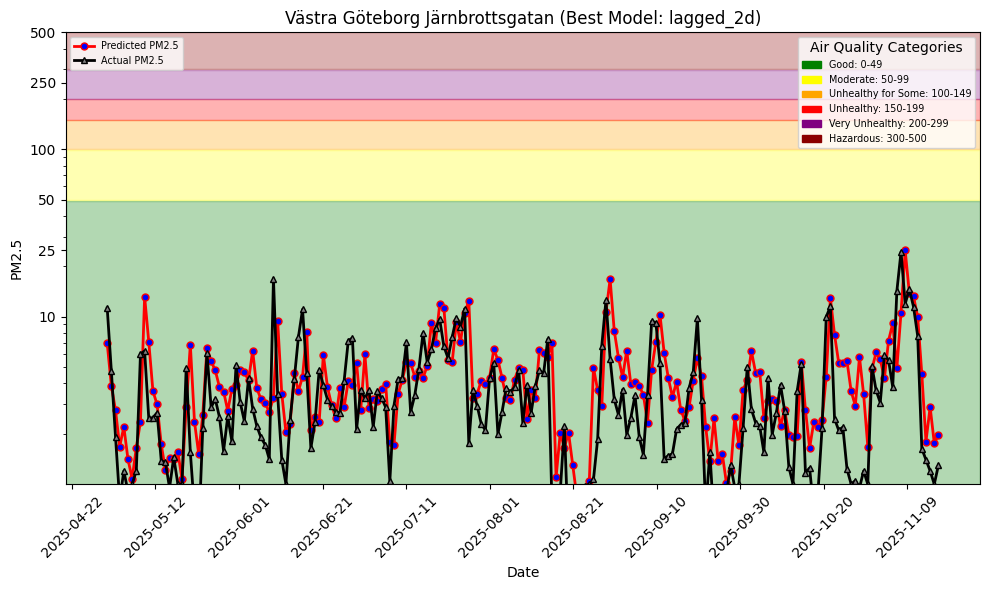

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/154549/model.json: 0.000%|          | 0/55…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/154549/images/importance.png: 0.000%|     …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/154549/images/hindcast_prediction.png: 0.0…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/154549/images/forecast.png: 0.000%|       …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/154549/images/hindcast_training.png: 0.000…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_154549/1


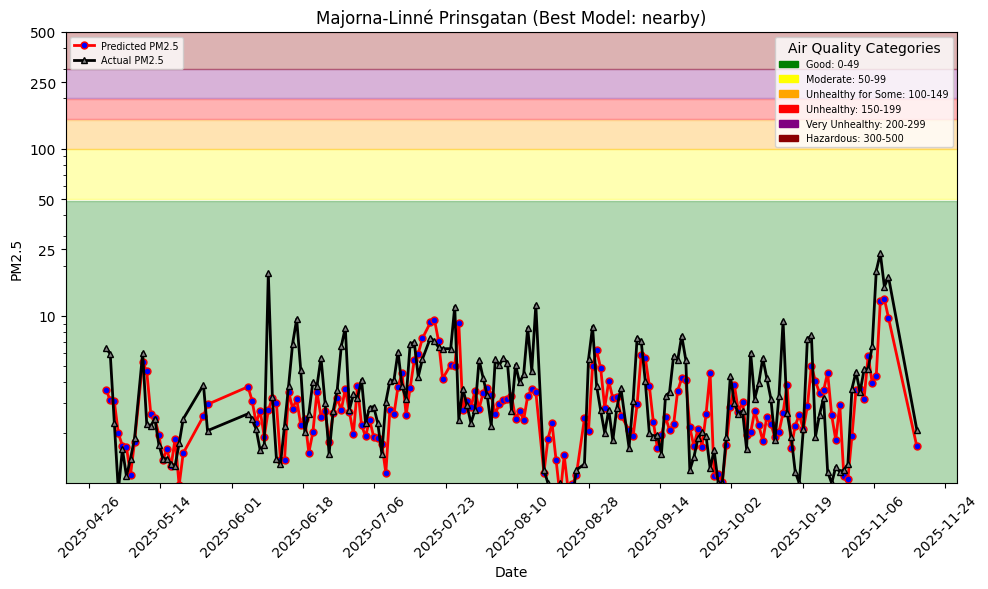

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60541/model.json: 0.000%|          | 0/567…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60541/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60541/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60541/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60541/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_60541/2


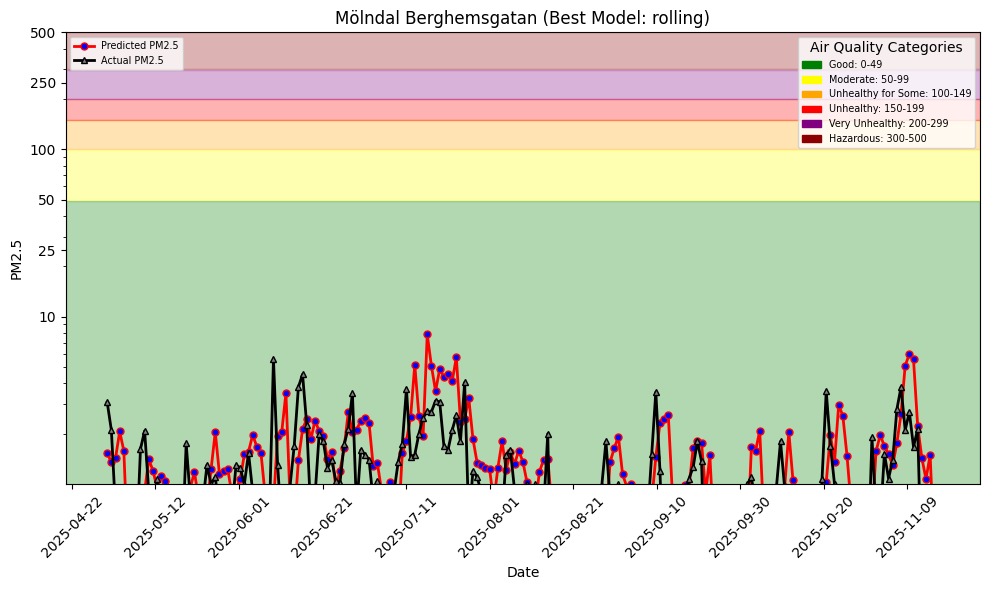

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/79750/model.json: 0.000%|          | 0/552…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/79750/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/79750/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/79750/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/79750/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_79750/1


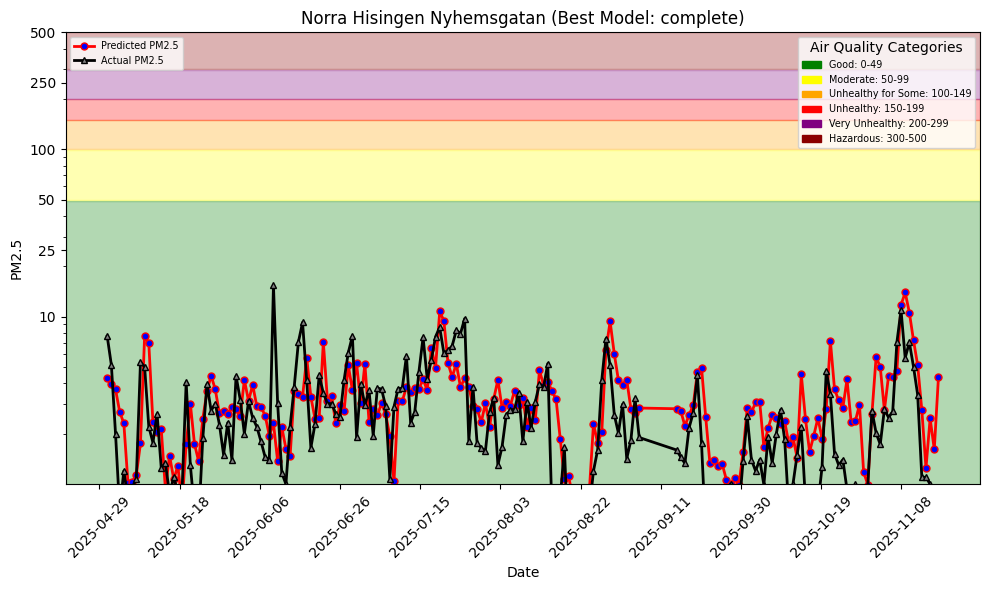

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/61714/model.json: 0.000%|          | 0/560…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/61714/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/61714/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/61714/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/61714/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_61714/1


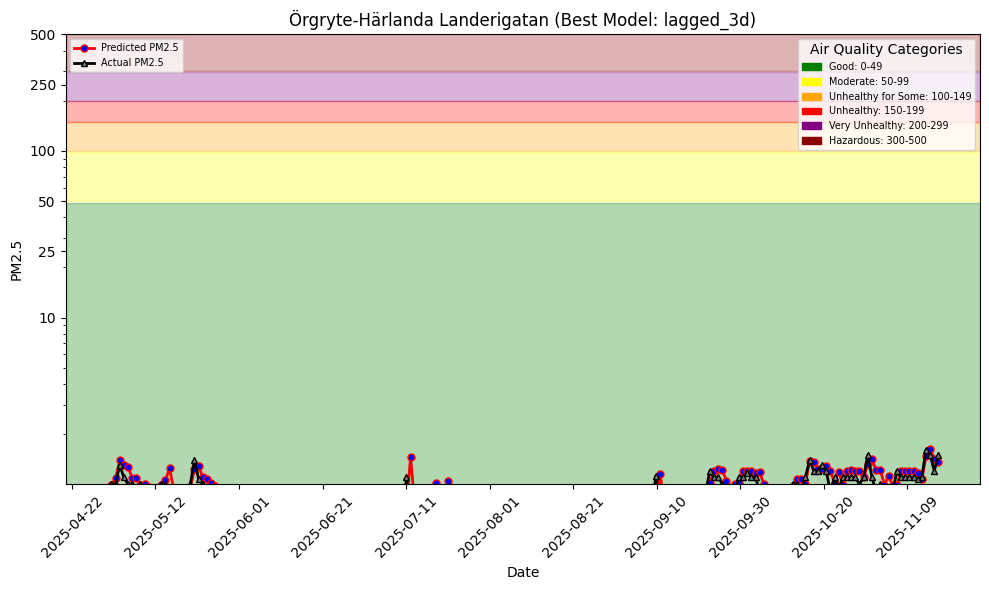

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/65146/model.json: 0.000%|          | 0/570…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/65146/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/65146/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/65146/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/65146/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_65146/1


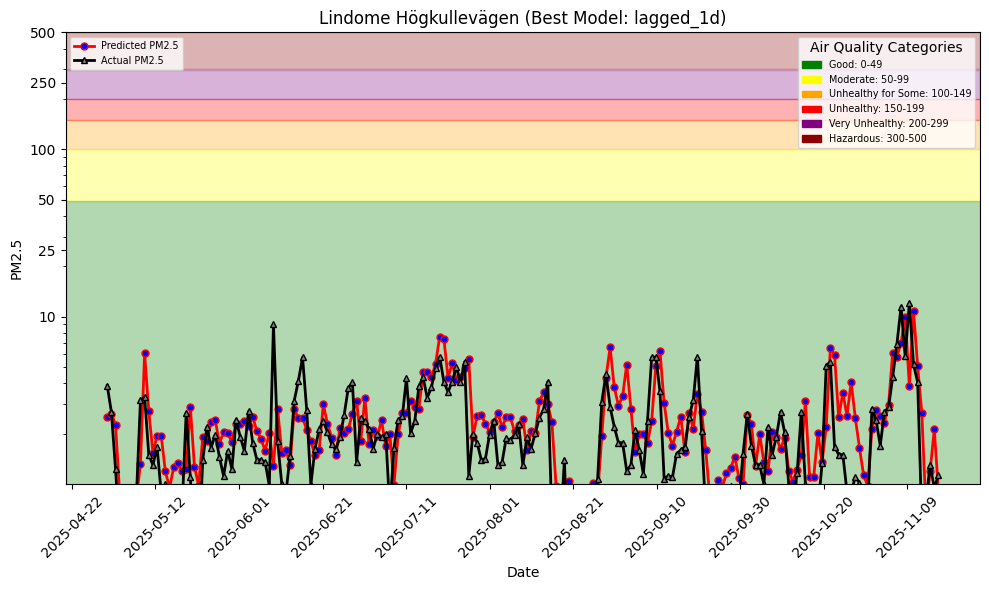

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/404209/model.json: 0.000%|          | 0/51…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/404209/images/importance.png: 0.000%|     …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/404209/images/hindcast_prediction.png: 0.0…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/404209/images/forecast.png: 0.000%|       …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/404209/images/hindcast_training.png: 0.000…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_404209/1


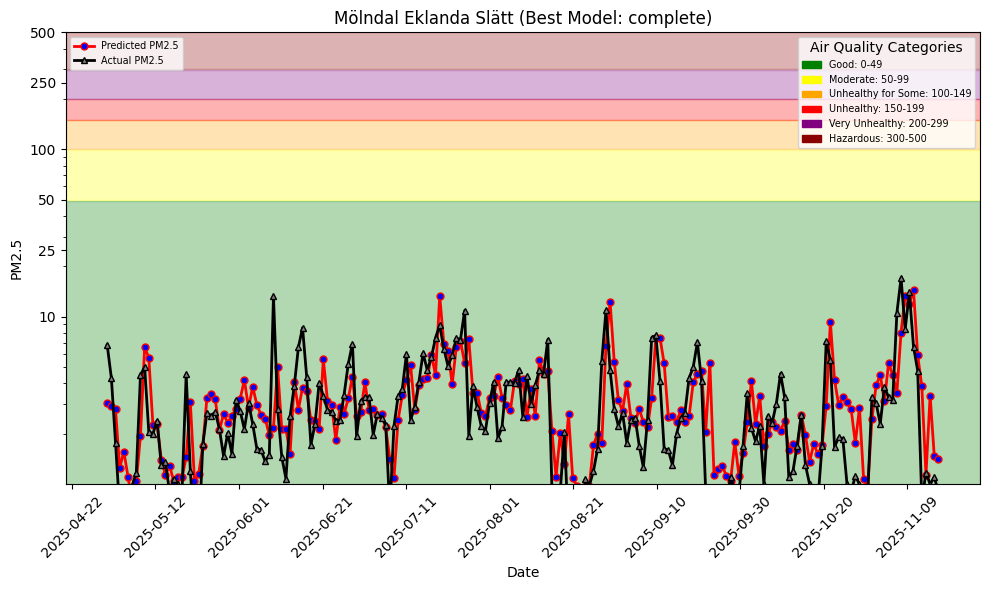

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59095/model.json: 0.000%|          | 0/583…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59095/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59095/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59095/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59095/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_59095/1


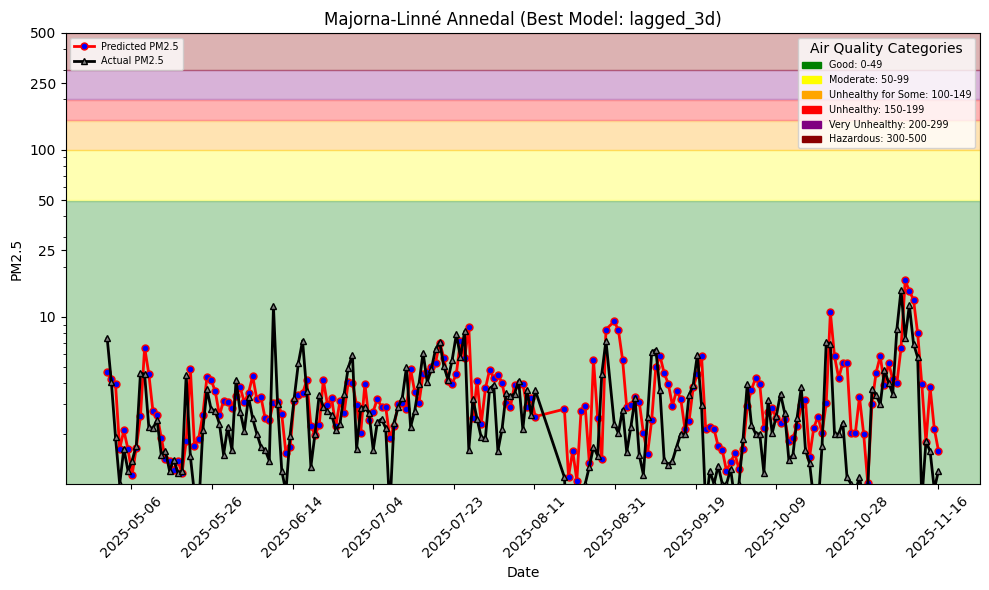

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60535/model.json: 0.000%|          | 0/590…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60535/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60535/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60535/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60535/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_60535/1


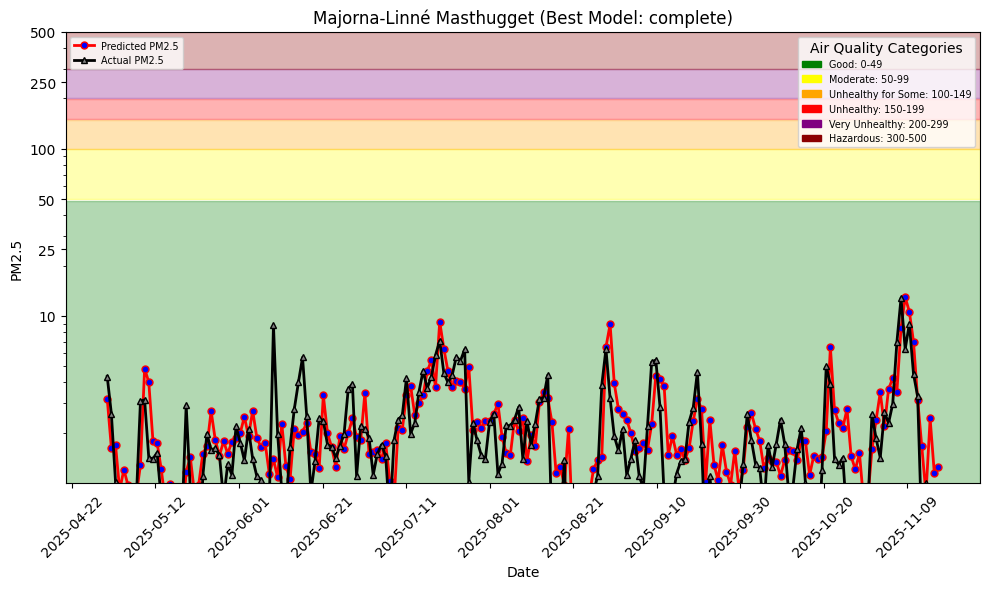

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60853/model.json: 0.000%|          | 0/568…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60853/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60853/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60853/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/60853/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_60853/1


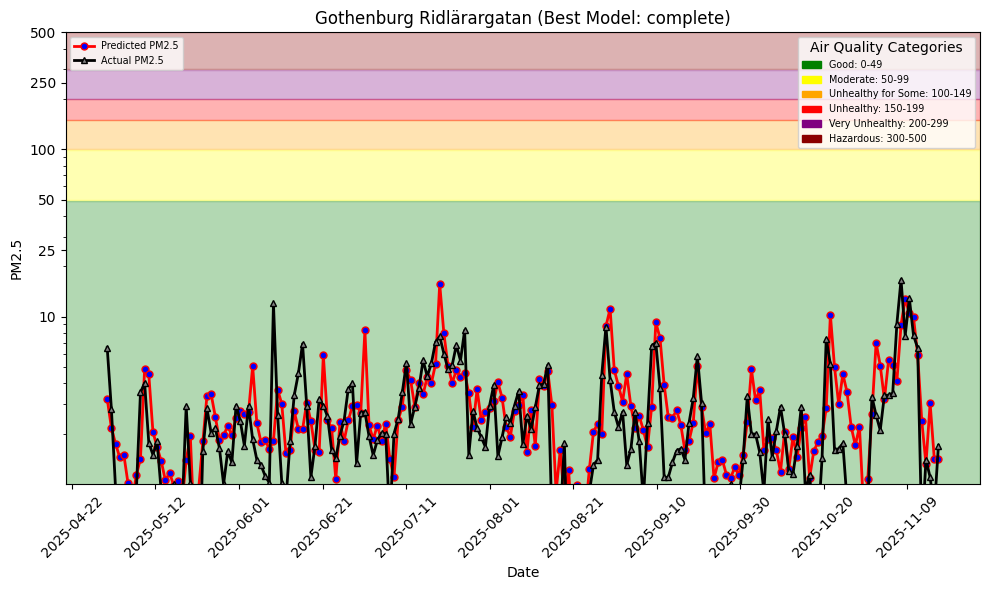

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/88372/model.json: 0.000%|          | 0/583…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/88372/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/88372/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/88372/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/88372/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_88372/1


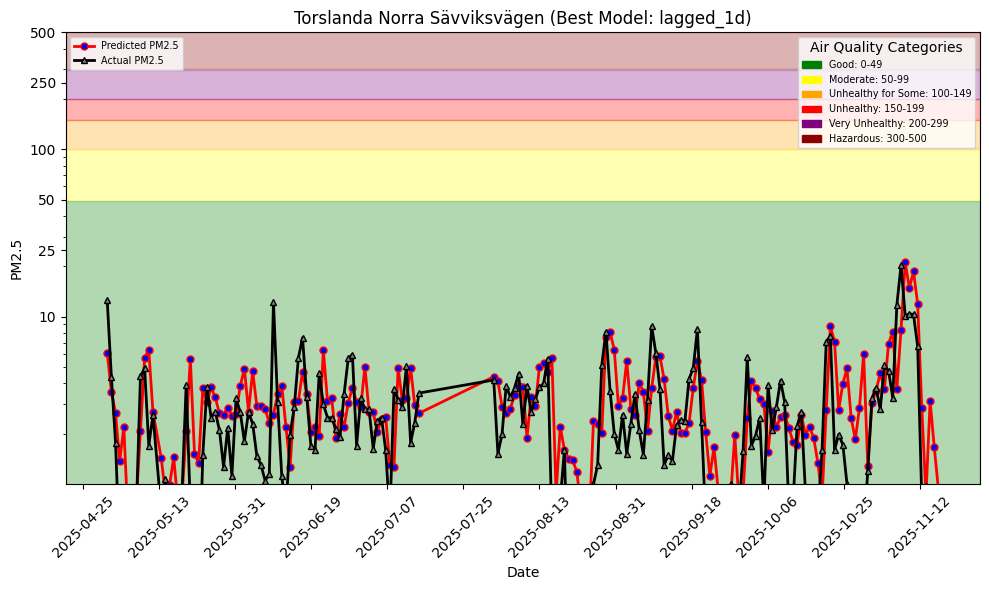

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/194215/model.json: 0.000%|          | 0/46…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/194215/images/importance.png: 0.000%|     …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/194215/images/hindcast_prediction.png: 0.0…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/194215/images/forecast.png: 0.000%|       …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/194215/images/hindcast_training.png: 0.000…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_194215/1


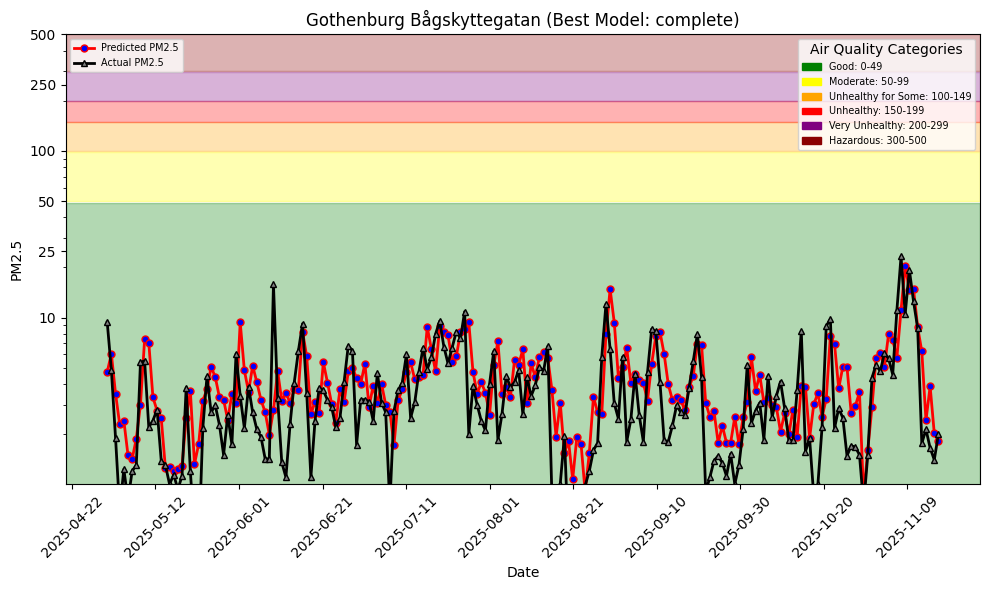

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/112672/model.json: 0.000%|          | 0/26…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/112672/images/importance.png: 0.000%|     …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/112672/images/hindcast_prediction.png: 0.0…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/112672/images/forecast.png: 0.000%|       …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/112672/images/hindcast_training.png: 0.000…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_112672/1


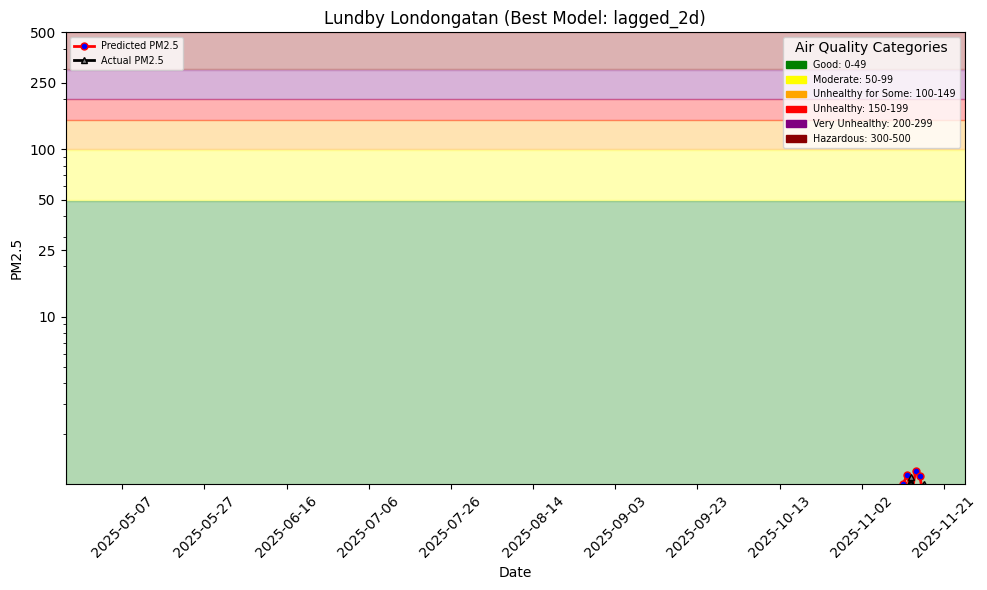

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59893/model.json: 0.000%|          | 0/519…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59893/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59893/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59893/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/59893/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_59893/1


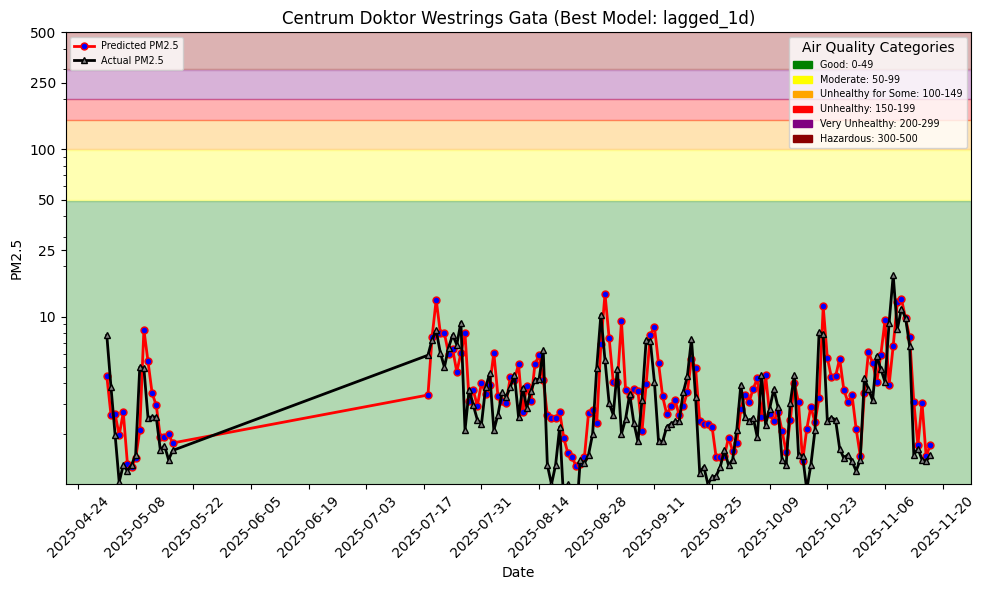

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69724/model.json: 0.000%|          | 0/557…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69724/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69724/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69724/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69724/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_69724/1


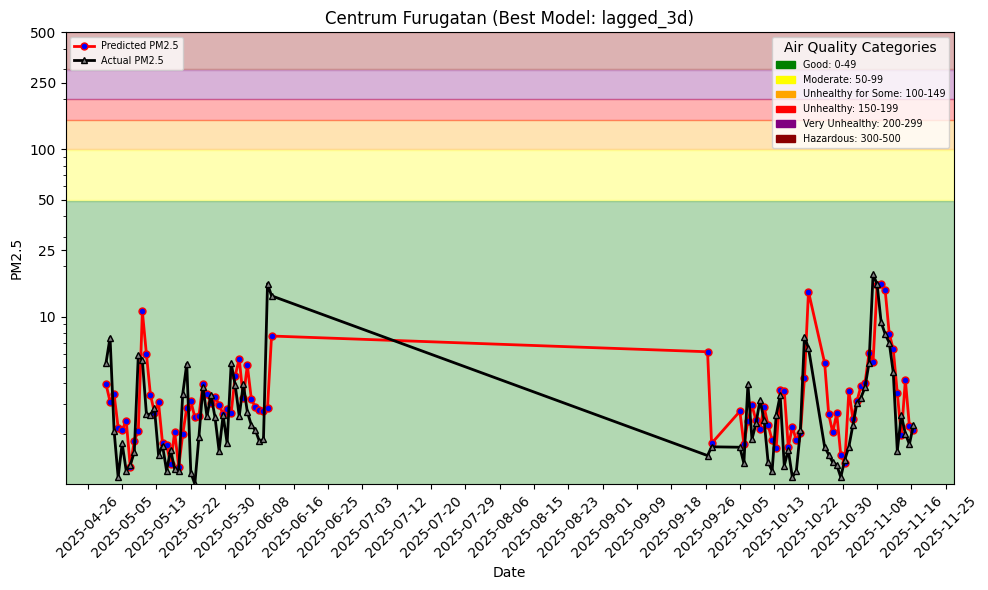

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/81505/model.json: 0.000%|          | 0/555…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/81505/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/81505/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_81505/1


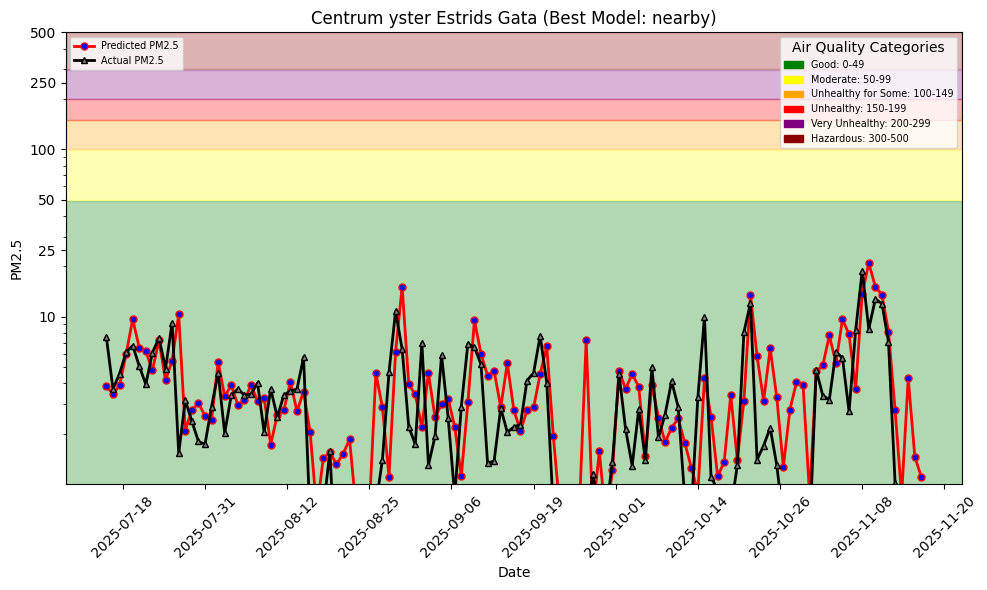

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69628/model.json: 0.000%|          | 0/550…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69628/images/importance.png: 0.000%|      …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69628/images/hindcast_prediction.png: 0.00…

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69628/images/forecast.png: 0.000%|        …

Uploading /Users/max/Repos/KTH/pm25-forecast-openmeteo-aqicn/models/69628/images/hindcast_training.png: 0.000%…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279179/models/air_quality_xgboost_model_69628/1


In [10]:
mr = project.get_model_registry()
df = pd.concat(all_test_data, ignore_index=True) if all_test_data else pd.DataFrame()
df = df.sort_values(by=["date"])

# Plot the best model for each sensor
for sensor_id, location in locations.items():
    city = location["city"]
    street = location["street"]
    latitude = location["latitude"]
    longitude = location["longitude"]
    
    df_subset = df[(df["latitude"] == latitude) & (df["longitude"] == longitude)].copy()
    if len(df_subset) == 0:
        continue
    
    # Get the best model name for display
    best_model_name = df_subset['best_model'].iloc[0] if 'best_model' in df_subset.columns else 'unknown'
    best_model_r2 = df_subset['R2'].iloc[0] if 'R2' in df_subset.columns else 0
    best_model_mse = df_subset['MSE'].iloc[0] if 'MSE' in df_subset.columns else 0
    best_model_feature_view = feature_views[best_model_name]
    
    df_subset = df_subset.sort_values(by=["date"])
    df_subset = df_subset.drop(columns=["latitude", "longitude", "best_model"])
    
    images_dir = f"{model_dir}/{sensor_id}/images"
    image_path = f"{images_dir}/hindcast_training.png"
    
    plt = airquality.plot_air_quality_forecast(
        city, street, df_subset, image_path, hindcast=True
    )
    plt.title(f"{city} {street} (Best Model: {best_model_name})")
    plt.show()

    # airquality.delete_models(mr, f"air_quality_xgboost_model_{sensor_id}")
    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_{sensor_id}",
        metrics={
            "R2": best_model_r2,
            "MSE": best_model_mse,
        },
        feature_view=best_model_feature_view,
        description=f"Air Quality (PM2.5) predictor for {city} {street} using {best_model_name} configuration",
    )

    aq_model.save(f"{model_dir}/{sensor_id}")
